In [1]:
from ndtools import staged_max_flow as smf
from typing import Any, Dict, List, Sequence, Tuple

from pathlib import Path
import json
import matplotlib as mpl
import matplotlib.pyplot as plt

from tsum import tsum
import torch

import time
import copy

# Utility functions

For use in plotting later.

In [4]:
def relabel_selected_keys(
    selected_keys: Sequence[str],
    nodes: Dict[str, Dict[str, Any]],
    edges: Dict[str, Dict[str, Any]],
    *,
    node_label: str = "node_id",
    edge_label_fmt: str = "({from_}, {to})",
    keep_unmatched: bool = True,
) -> List[str]:
    """
    Given a list of comp_id keys (e.g., ['x1','x29',...]), return a same-length list
    where each key is replaced by:
      - node label (default: node id like 'n1') if comp_id matches a node
      - '(from,to)' if comp_id matches an edge
    First match wins if multiple components share a comp_id.
    Node takes precedence over edge if both match.
    """

    # Build comp_id -> label lookup (first match wins)
    comp_to_label: Dict[str, str] = {}

    # Nodes first (node precedence)
    for n_id, n in nodes.items():
        comp_id = n.get("comp_id")
        if comp_id and comp_id not in comp_to_label:
            # Default behaviour: label is the node key, e.g., 'n1'
            comp_to_label[comp_id] = n_id if node_label == "node_id" else str(n.get(node_label, n_id))

    # Then edges
    for _, e in edges.items():
        comp_id = e.get("comp_id")
        if comp_id and comp_id not in comp_to_label:
            comp_to_label[comp_id] = edge_label_fmt.format(from_=e.get("from"), to=e.get("to"))

    # Map list -> list (same length, order preserved)
    out_keys: List[str] = []
    for k in selected_keys:
        if k in comp_to_label:
            out_keys.append(comp_to_label[k])
        else:
            if keep_unmatched:
                out_keys.append(k)
            else:
                continue

    return out_keys

# System reliability

## Case 1: Original system

First load data.

In [5]:
DATASET = Path(r"data") 

nodes = json.loads((DATASET / "nodes.json").read_text(encoding="utf-8"))
edges = json.loads((DATASET / "edges.json").read_text(encoding="utf-8"))
probs_dict = json.loads((DATASET / "probs.json").read_text(encoding="utf-8"))


In [6]:
def s_fun(comps_st):
    flow, sys_st_str, min_comp_state = smf.sys_fun( comps_st, nodes, edges, probs_dict, target_flow = 0.5 )

    sys_st = 1 if sys_st_str == 's' else 0
    return flow, sys_st, None

row_names = list(probs_dict.keys())
n_state = 2  # binary states: 0, 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
probs = [[probs_dict[n]['0']['p'], probs_dict[n]['1']['p']] for n in row_names]
probs = torch.tensor(probs, dtype=torch.float32, device=device)

In [56]:
TSUMPATH = Path("tsum_res")

sys_surv_st = 1  # system survival state

rules_mat_surv = torch.load(TSUMPATH / f"rules_geq_{sys_surv_st}.pt", map_location="cpu")
rules_mat_surv = rules_mat_surv.to(device)
rules_mat_fail = torch.load(TSUMPATH / f"rules_leq_{sys_surv_st-1}.pt", map_location="cpu")
rules_mat_fail = rules_mat_fail.to(device)

## System marginal probability

In [10]:
st = time.time()

pr_cond = tsum.get_comp_cond_sys_prob(
    rules_mat_surv,
    rules_mat_fail,
    probs,
    comps_st_cond = {},
    row_names = row_names,
    s_fun = s_fun,
    sys_surv_st = sys_surv_st,
    n_sample = 10_000_000
)

et = time.time()
print(f"Time elapsed: {et - st:.2f} seconds\n")
print(f"P(sys >= {sys_surv_st}) = {pr_cond['survival']:.3e}")
print(f"P(sys <= {sys_surv_st-1} ) = {pr_cond['failure']:.3e}\n")

Time elapsed: 22.81 seconds

P(sys >= 1) = 7.707e-01
P(sys <= 0 ) = 2.293e-01



# Component Importance Measures

## Case 1: Birnbaum's measure

$BI(x) = P(S=1 | X=1) - P(S=1 | X=0)$

In [58]:
bms_dict = {}

for x in probs_dict.keys():
    print(f"Calculating BM for {x}..")
    
    ps1_x1 = tsum.get_comp_cond_sys_prob(
        rules_mat_surv,
        rules_mat_fail,
        probs,
        comps_st_cond = {x: 1},
        row_names = row_names,
        s_fun = s_fun,
        sys_surv_st = sys_surv_st,
        n_sample = 10_000_000
    )

    ps1_x0 = tsum.get_comp_cond_sys_prob(
        rules_mat_surv,
        rules_mat_fail,
        probs,
        comps_st_cond = {x: 0},
        row_names = row_names,
        s_fun = s_fun,
        sys_surv_st = sys_surv_st,
        n_sample = 10_000_000
    )

    bm_x = max([0, ps1_x1['survival'] - ps1_x0['survival']])
    bms_dict[x] = bm_x

    print(f"BM({x}) = {bm_x:.3e}\n")

out_path = TSUMPATH / "bms.json"
with open(out_path, "w") as f:
    json.dump(bms_dict, f, indent=4)


Calculating BM for x1..
BM(x1) = 4.679e-02

Calculating BM for x2..
BM(x2) = 4.683e-02

Calculating BM for x3..
BM(x3) = 4.640e-05

Calculating BM for x4..
BM(x4) = 0.000e+00

Calculating BM for x5..
BM(x5) = 0.000e+00

Calculating BM for x6..
BM(x6) = 0.000e+00

Calculating BM for x7..
BM(x7) = 0.000e+00

Calculating BM for x8..
BM(x8) = 0.000e+00

Calculating BM for x9..
BM(x9) = 0.000e+00

Calculating BM for x10..
BM(x10) = 0.000e+00

Calculating BM for x11..
BM(x11) = 2.243e-04

Calculating BM for x12..
BM(x12) = 1.503e-04

Calculating BM for x13..
BM(x13) = 0.000e+00

Calculating BM for x14..
BM(x14) = 0.000e+00

Calculating BM for x15..
BM(x15) = 7.000e-06

Calculating BM for x16..
BM(x16) = 0.000e+00

Calculating BM for x17..
BM(x17) = 0.000e+00

Calculating BM for x18..
BM(x18) = 0.000e+00

Calculating BM for x19..
BM(x19) = 1.019e-04

Calculating BM for x20..
BM(x20) = 1.613e-04

Calculating BM for x21..
BM(x21) = 1.326e-04

Calculating BM for x22..
BM(x22) = 0.000e+00

Calcul

Plot the results.

In [ ]:
"""
TSUMPATH = Path("tsum_res")
out_path = TSUMPATH / "bms.json"
with open(out_path, "r") as f:
    bms_dict = json.load(f)
"""

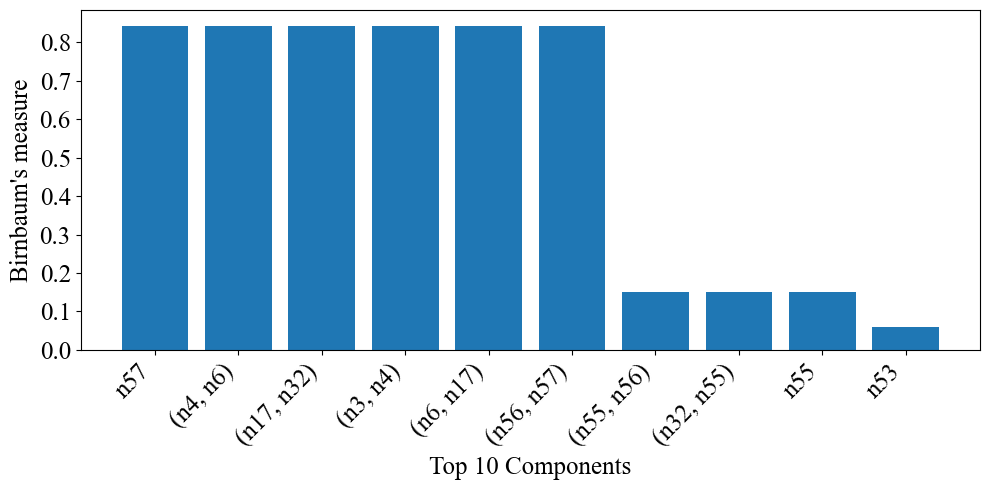

In [28]:
n_data_vis = 10 # number of components to visualise, in descending order of Birnbaum's measure
FONT_FAMILY = "Times New Roman"
LABEL_SIZE = 18
TICK_SIZE = 18

# Get top n_data_vis components by Birnbaum's measure
bms_sorted = sorted(bms_dict.items(), key=lambda item: item[1], reverse=True)
top_bms = bms_sorted[:n_data_vis]
keys, values = zip(*top_bms)

# Relabel keys for better readability
keys_rlb = relabel_selected_keys(keys, nodes, edges)

# save figure
FIGPATH = "figs"
Path(FIGPATH).mkdir(parents=True, exist_ok=True)

# Plot
mpl.rcParams["font.family"] = FONT_FAMILY

plt.figure(figsize=(10, 5))
plt.bar(keys_rlb, values)
plt.xlabel("Top 10 Components", fontsize=LABEL_SIZE)
plt.ylabel("Birnbaum's measure", fontsize=LABEL_SIZE)
plt.xticks(rotation=45, ha="right", fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)
plt.tight_layout()
out_path = Path(FIGPATH) / "bm_top10.png"
plt.savefig(out_path, dpi=300)
plt.show()

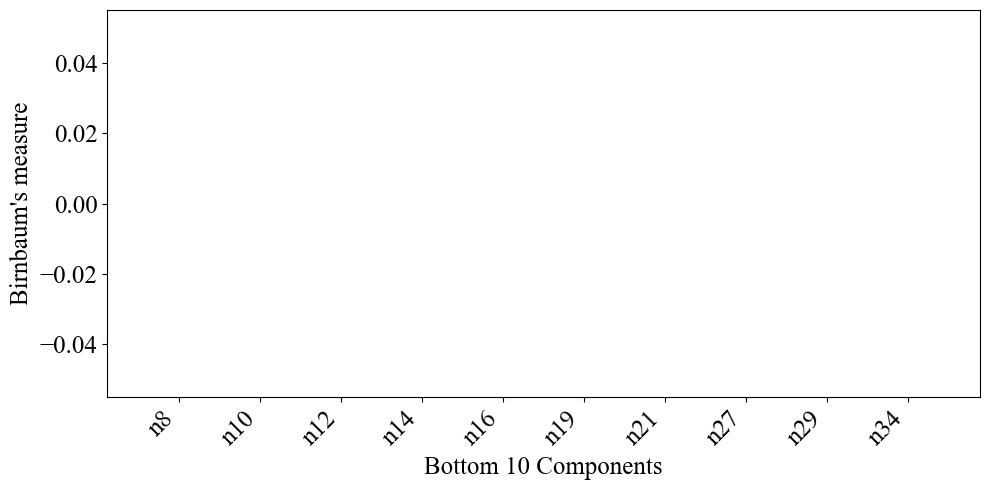

In [31]:
n_data_vis = 10 # number of components to visualise, in descending order of Birnbaum's measure
FONT_FAMILY = "Times New Roman"
LABEL_SIZE = 18
TICK_SIZE = 18

# Get top n_data_vis components by Birnbaum's measure
bms_sorted = sorted(bms_dict.items(), key=lambda item: item[1], reverse=False)
top_bms = bms_sorted[:n_data_vis]
keys, values = zip(*top_bms)

# Relabel keys for better readability
keys_rlb = relabel_selected_keys(keys, nodes, edges)

# save figure
FIGPATH = "figs"
Path(FIGPATH).mkdir(parents=True, exist_ok=True)

# Plot
mpl.rcParams["font.family"] = FONT_FAMILY

plt.figure(figsize=(10, 5))
plt.bar(keys_rlb, values)
plt.xlabel("Bottom 10 Components", fontsize=LABEL_SIZE)
plt.ylabel("Birnbaum's measure", fontsize=LABEL_SIZE)
plt.xticks(rotation=45, ha="right", fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)
plt.tight_layout()
out_path = Path(FIGPATH) / "bm_low10.png"
plt.savefig(out_path, dpi=300)
plt.show()

## Case 2: Addition Importance Measure

This measure quantifies the increase in system reliability when the same component is added to the system.

This can be computed by creating a duplicate of the component in the system structure, and evaluating the system reliability with the duplicated component working.

This measure is not officially included in the publication because it does not give additional insights compared to Birnbaum's measure.
Yet it is implemented here for demonstration purposes.

In [46]:
out_dir = Path("tsum_res_aim")
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / "aims.json"

In [49]:
sys_surv_st = 1
aim_dict = {}

for x in probs_dict.keys():
    print(f"Adding component: {x}..")

    new_nodes, new_edges, new_probs = smf.add_a_component(x, nodes, edges, probs_dict)

    def s_fun(comps_st):
        flow, sys_st_str, min_comp_state = smf.sys_fun( comps_st, new_nodes, new_edges, new_probs, target_flow = 0.5 )

        sys_st = 1 if sys_st_str == 's' else 0
        return flow, sys_st, None
    
    row_names = list(new_probs.keys())
    n_state = 2  # binary states: 0, 1
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    probs = [[new_probs[n]['0']['p'], new_probs[n]['1']['p']] for n in row_names]
    probs = torch.tensor(probs, dtype=torch.float32, device=device)

    # load rules
    TSUMPATH = Path(rf"tsum_res_aim/{x}")

    sys_surv_st = 1  # system survival state

    rules_mat_surv = torch.load(TSUMPATH / f"rules_geq_{sys_surv_st}.pt", map_location="cpu")
    rules_mat_surv = rules_mat_surv.to(device)
    rules_mat_fail = torch.load(TSUMPATH / f"rules_leq_{sys_surv_st-1}.pt", map_location="cpu")
    rules_mat_fail = rules_mat_fail.to(device)

    # Run analysis
    st = time.time()
    pr_cond_x = tsum.get_comp_cond_sys_prob(
        rules_mat_surv,
        rules_mat_fail,
        probs,
        comps_st_cond = {},
        row_names = row_names,
        s_fun = s_fun,
        sys_surv_st = sys_surv_st,
        n_sample = 10_000_000
    )
    et = time.time()
    print(f"Time elapsed: {et - st:.2f} seconds\n")

    aim_x = max( [pr_cond['failure'] - pr_cond_x['failure'], 0] )
    aim_dict[x] = aim_x

    print(f"AIM({x}) = {aim_x:.3e}\n")

with open(out_path, "w") as f:
    json.dump(aim_dict, f, indent=4)

Adding component: x1..
Time elapsed: 27.83 seconds

AIM(x1) = 1.139e-03

Adding component: x2..
Time elapsed: 29.50 seconds

AIM(x2) = 9.425e-04

Adding component: x3..
Time elapsed: 28.02 seconds

AIM(x3) = 0.000e+00

Adding component: x4..
Time elapsed: 27.29 seconds

AIM(x4) = 0.000e+00

Adding component: x5..
Time elapsed: 27.83 seconds

AIM(x5) = 0.000e+00

Adding component: x6..
Time elapsed: 30.81 seconds

AIM(x6) = 3.840e-05

Adding component: x7..
Time elapsed: 28.24 seconds

AIM(x7) = 0.000e+00

Adding component: x8..
Time elapsed: 29.44 seconds

AIM(x8) = 0.000e+00

Adding component: x9..
Time elapsed: 26.53 seconds

AIM(x9) = 0.000e+00

Adding component: x10..
Time elapsed: 25.81 seconds

AIM(x10) = 0.000e+00

Adding component: x11..
Time elapsed: 29.74 seconds

AIM(x11) = 0.000e+00

Adding component: x12..
Time elapsed: 26.83 seconds

AIM(x12) = 0.000e+00

Adding component: x13..
Time elapsed: 28.07 seconds

AIM(x13) = 0.000e+00

Adding component: x14..
Time elapsed: 28.31

Plot the results.

In [48]:
# Load AIM if data available from cells above
"""
aim_path = Path("tsum_res_aim") / "aims.json"

with open(aim_path, "r") as f:
    aim_dict = json.load(f)
"""

'\naim_path = Path("tsum_res_aim") / "aims.json"\n\nwith open(aim_path, "r") as f:\n    aim_dict = json.load(f)\n'

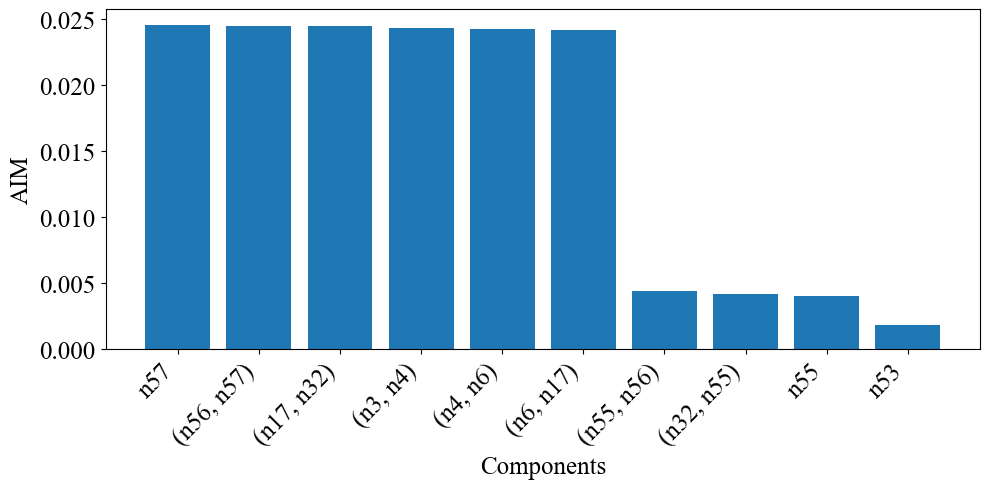

In [51]:
n_data_vis = 10 # number of components to visualise, in descending order of AIM
FONT_FAMILY = "Times New Roman"
LABEL_SIZE = 18
TICK_SIZE = 18

# Get top n_data_vis components by AIM
aims_sorted = sorted(aim_dict.items(), key=lambda item: item[1], reverse=True)
top_aims = aims_sorted[:n_data_vis]
keys, values = zip(*top_aims)

# Relabel keys for better readability
keys_rlb = relabel_selected_keys(keys, nodes, edges)

# Plot
mpl.rcParams["font.family"] = FONT_FAMILY

plt.figure(figsize=(10, 5))
plt.bar(keys_rlb, values)
plt.xlabel("Components", fontsize=LABEL_SIZE)
plt.ylabel("AIM", fontsize=LABEL_SIZE)
plt.xticks(rotation=45, ha="right", fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)
plt.tight_layout()
plt.show()

## Case 3: Deactivation Importance Measures (DIM)

This measure quantifies the decrease in system reliability when the component is removed from the system.

This can be computed by removing the components, and evaluating the system reliability without the removed component.

This measure is not officially included in the publication because it does not give additional insights compared to Birnbaum's measure.
Yet it is implemented here for demonstration purposes.

In [19]:
out_dir = Path("tsum_res_dim")
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / "dims.json"

In [ ]:
sys_surv_st = 1
dim_dict = {}

for x in probs_dict.keys():
    print(f"Deactivating component: {x}..")

    new_nodes, new_edges, new_probs = smf.deactivate_a_component(x, nodes, edges, probs_dict)

    def s_fun(comps_st):
        flow, sys_st_str, min_comp_state = smf.sys_fun( comps_st, new_nodes, new_edges, new_probs, target_flow = 0.5 )

        sys_st = 1 if sys_st_str == 's' else 0
        return flow, sys_st, None
    
    row_names = list(new_probs.keys())
    n_state = 2  # binary states: 0, 1
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    probs = [[new_probs[n]['0']['p'], new_probs[n]['1']['p']] for n in row_names]
    probs = torch.tensor(probs, dtype=torch.float32, device=device)

    # load rules
    TSUMPATH = Path(rf"tsum_res_dim/{x}")

    sys_surv_st = 1  # system survival state

    rules_mat_surv = torch.load(TSUMPATH / f"rules_geq_{sys_surv_st}.pt", map_location="cpu")
    rules_mat_surv = rules_mat_surv.to(device)
    rules_mat_fail = torch.load(TSUMPATH / f"rules_leq_{sys_surv_st-1}.pt", map_location="cpu")
    rules_mat_fail = rules_mat_fail.to(device)

    # Run analysis
    st = time.time()
    pr_cond_x = tsum.get_comp_cond_sys_prob(
        rules_mat_surv,
        rules_mat_fail,
        probs,
        comps_st_cond = {},
        row_names = row_names,
        s_fun = s_fun,
        sys_surv_st = sys_surv_st,
        n_sample = 10_000_000
    )
    et = time.time()
    print(f"Time elapsed: {et - st:.2f} seconds\n")

    dim_x = max( [pr_cond_x['failure'] - pr_cond['failure'], 0] )
    dim_dict[x] = dim_x

    print(f"DIM({x}) = {dim_x:.3e}\n")

with open(out_path, "w") as f:
    json.dump(dim_dict, f, indent=4)